# Winning Jeopardy using statistical analysis
Can we identify what to study in order to win at Jeopardy from looking at past questions and answers, and their value? Let's try by answering these questions:
* Are answers deducible from questions, ie. do words in the answer appear in the question?
* Do question words repeat themselves over the years, such that past questions are worth studying?
* Do the high value questions have common words?

The data set used in this project can be found [here](https://www.reddit.com/r/datasets/comments/1uyd0t/200000_jeopardy_questions_in_a_json_file/).
## Reading the data

In [67]:
import pandas as pd
jeopardy = pd.read_csv('jeopardy.csv')
jeopardy.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


## Cleaning the data
In order to have data that can be analyzed, let's do the following:
* Remove extra whitespace from column names
* Remove anything that isn't an alphanumerical character from our questions and answers
* Convert question values to int type
* Convert air date to datetime type

In [68]:
jeopardy.columns

Index(['Show Number', ' Air Date', ' Round', ' Category', ' Value',
       ' Question', ' Answer'],
      dtype='object')

In [69]:
jeopardy.columns = jeopardy.columns.str.strip()
jeopardy.columns

Index(['Show Number', 'Air Date', 'Round', 'Category', 'Value', 'Question',
       'Answer'],
      dtype='object')

In [70]:
import re

# remove non alpha numerical characters from questions and answers
def normalize(element):
    return re.sub("[^A-Za-z0-9\s]", "", element.lower())

jeopardy['clean_question'] = jeopardy['Question'].apply(normalize)
jeopardy['clean_answer'] = jeopardy['Answer'].apply(normalize)

In [71]:
# remove dollar symbol and convert to int
def normalize_value(element):
    try:
        return int(normalize(element.replace('$','')))
    except:
        return 0

jeopardy['clean_value'] = jeopardy['Value'].apply(normalize_value)

jeopardy['Air Date'] = pd.to_datetime(jeopardy['Air Date'])
jeopardy.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer,clean_question,clean_answer,clean_value
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus,for the last 8 years of his life galileo was u...,copernicus,200
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,no 2 1912 olympian football star at carlisle i...,jim thorpe,200
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona,the city of yuma in this state has a record av...,arizona,200
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,in 1963 live on the art linkletter show this c...,mcdonalds,200
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,signer of the dec of indep framer of the const...,john adams,200


## Analyzing the data
### Word match between questions and answers
Let's first count the average matches between answer words and question words. To do this, we split answers and questions into words (removing 'the', which will likely appear in both questions and answers very often), and sum up how many times a word from the answer appears in the question.

In [72]:
def answer_match_questions(row):
    split_answer = row['clean_answer'].split(' ')
    while 'the' in split_answer:
        split_answer.remove('the')
    if len(split_answer) == 0:
        return 0
    else:
        split_question = row['clean_question'].split(' ')
        match_count = 0
        for word in split_answer:
            if word in split_question:
                match_count +=1
        return match_count / len(split_answer)

jeopardy['answer_in_question'] = jeopardy.apply(answer_match_questions, axis=1)
print(jeopardy['answer_in_question'].mean())

0.0598776075999938


On average, few words in the answers show up in the questions: only about 6% of the time.

### Frequent words in questions
Let's find out how often terms come back accross questions over the years. To do this, we sort the data by airdate, split the questions into words, keep only the long words (more than 5 characters), and count the number of words that have appeared previously divided by the length of the question. At the end of each iteration, we add the words to the set of words used previously.

In [73]:
jeopardy = jeopardy.sort_values(by='Air Date')
question_overlap = []
terms_used = set()
for i, row in jeopardy.iterrows():
    split_question = row['clean_question'].split(' ')
    split_question = [word for word in split_question if len(word)>5]
    match_count = 0
    for word in split_question:
        if word in terms_used:
            match_count +=1
    for word in split_question:
        terms_used.add(word)
    if len(split_question) > 0:
        match_count = match_count/len(split_question)
    question_overlap.append(match_count)

jeopardy['question_overlap'] = question_overlap
print(jeopardy['question_overlap'].mean())

0.6876260592169776


It seems that words in questions reappear often. On average, 68% of the words in a question appeared in previous questions, this is better than words in answers appearing in their corresponding questions, but need more investigation to make sure.

### High value question words
#### Cleaning the words used set
Let's identify which words appear often in high value questions, that is questions with a value greater than $800. First, let's try and trim our set of words used of stopwords and other junk words.

In [74]:
stopwords=(['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', "can't", 'cannot', 'could', "couldn't", 'did', "didn't", 'do', 'does', "doesn't", 'doing', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', "here's", 'hers', 'herself', 'him', 'himself', 'his', 'how', "how's", 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', "isn't", 'it', "it's", 'its', 'itself', "let's", 'me', 'more', 'most', "mustn't", 'my', 'myself', 'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'same', "shan't", 'she', "she'd", "she'll", "she's", 'should', "shouldn't", 'so', 'some', 'such', 'than', 'that', "that's", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', "there's", 'these', 'they', "they'd", "they'll", "they're", "they've", 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 'very', 'was', "wasn't", 'we', "we'd", "we'll", "we're", "we've", 'were', "weren't", 'what', "what's", 'when', "when's", 'where', "where's", 'which', 'while', 'who', "who's", 'whom', 'why', "why's", 'with', "won't", 'would', "wouldn't", 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours', 'yourself', 'yourselves'])
print(len(terms_used))
for word in stopwords:
    terms_used.discard(word)
print(len(terms_used))

24469
24452


We removed a few words from our set, let's look at the length of those remaining to identify potential junk words.

(array([1.9984e+04, 2.9720e+03, 2.6600e+02, 2.3000e+01, 4.0000e+00,
        0.0000e+00, 0.0000e+00, 9.8700e+02, 2.0500e+02, 1.1000e+01]),
 array([ 6. , 10.8, 15.6, 20.4, 25.2, 30. , 34.8, 39.6, 44.4, 49.2, 54. ]),
 <a list of 10 Patch objects>)

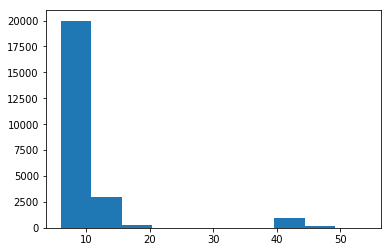

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline
word_lengths = [len(word) for word in terms_used]
plt.hist(word_lengths)

There are words with 40+ characters! Let's investigate.

In [76]:
problem_words = [word for word in terms_used if len(word)>20]
problem_words

['hrefhttpwwwjarchivecommedia20050502dj21jpg',
 'hrefhttpwwwjarchivecommedia20050303dj12jpg',
 'hrefhttpwwwjarchivecommedia20070724j02jpg',
 'hrefhttpwwwjarchivecommedia20101207j26ajpg',
 'hrefhttpwwwjarchivecommedia20010904j22jpg',
 'hrefhttpwwwjarchivecommedia20061016dj16mp3i',
 'hrefhttpwwwjarchivecommedia20090211j28wmvthisa',
 'hrefhttpwwwjarchivecommedia20100604dj10ajpg',
 'hrefhttpwwwjarchivecommedia20061102j02ajpg',
 'hrefhttpwwwjarchivecommedia20080602dj18mp3dag',
 'hrefhttpwwwjarchivecommedia20040706dj30jpg',
 'hrefhttpwwwjarchivecommedia20080926dj27ajpg',
 'hrefhttpwwwjarchivecommedia20040707dj12ajpg',
 'hrefhttpwwwjarchivecommedia20090514dj24wmvthesea',
 'hrefhttpwwwjarchivecommedia20101104dj14jpg',
 'hrefhttpwwwjarchivecommedia20050411j29jpg',
 'hrefhttpwwwjarchivecommedia20090105dj12jpg',
 'hrefhttpwwwjarchivecommedia20110712dj25ajpg',
 'hrefhttpwwwjarchivecommedia20050629j10ajpg',
 'hrefhttpwwwjarchivecommedia20010904dj12jpg',
 'hrefhttpwwwjarchivecommedia20071106dj10jpga

These are junk: urls for pictures. Let's remove them.

(array([10209.,  4345.,  5430.,  1363.,   794.,   685.,   130.,   188.,
           34.,    44.]),
 array([ 6. ,  7.4,  8.8, 10.2, 11.6, 13. , 14.4, 15.8, 17.2, 18.6, 20. ]),
 <a list of 10 Patch objects>)

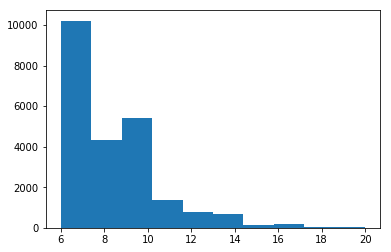

In [77]:
terms_used = set([word for word in terms_used if len(word) <=20])
word_lengths = [len(word) for word in terms_used]
plt.hist(word_lengths)

Better, let's see what's left between 10 and 20 characters.

In [78]:
problem_words = [word for word in terms_used if len(word)>10]
problem_words

['anesthetized',
 'millionfooted',
 'compositions',
 'physiotherapy',
 'experienced',
 'luminescent',
 'interpretation',
 'grammatically',
 'diminuitive',
 'anthropologist',
 'wellingtons',
 'chomolungma',
 'trusteeship',
 'poetplaywright',
 'atmospheric',
 'gravitational',
 'communication',
 'insecurities',
 'spokespersons',
 'fireroasted',
 'longtrumpet',
 'postcentral',
 'experimental',
 'quarantines',
 'prevarication',
 'semiconducting',
 'punctuality',
 'appropriatesounding',
 'backwardcurving',
 'targetblankhis',
 'netherlands',
 'observations',
 'lesseraltitude',
 'interrogation',
 'whaleheaded',
 'allmusiccom',
 'originating',
 'everythingi',
 'alexandrite',
 'tournaments',
 'arabisraeli',
 'kidneyshaped',
 'organizational',
 'voraciously',
 'miserablesounds',
 'phenomenally',
 'dreigroschenoper',
 'contradiction',
 'alphanumeric',
 'disappointment',
 'compositors',
 'everpresent',
 'indulgences',
 'commissioned',
 'murderesses',
 'christendom',
 'broadleafed',
 'fingernailtapp

There are some legitimate words, while others are junk. Because we have so many words already, let's restrict our data further so that it can be analyzed in reasonable time. We will limit to a sample of ~200 words between 5 and 10 characters.

In [109]:
from numpy import random
terms_used = set([word for word in terms_used if len(word) <=10])
sample_terms = set(random.choice(list(terms_used),200))
len(sample_terms)

198

In [110]:
sample_terms

{'105room',
 '65million',
 'abilities',
 'acasta',
 'accuser',
 'aeneid',
 'albino',
 'algerian',
 'amends',
 'amicably',
 'appetites',
 'artist',
 'atlantic',
 'aviator',
 'awkward',
 'bandaids',
 'belgrade',
 'belize',
 'binoche',
 'bleachers',
 'bogart',
 'bordering',
 'braided',
 'brooke',
 'burlap',
 'cabrini',
 'calculator',
 'camden',
 'centessimi',
 'certified',
 'channel',
 'chapmans',
 'chariots',
 'cheeses',
 'christs',
 'claire',
 'coffin',
 'columbines',
 'confession',
 'consul',
 'cooperate',
 'coopers',
 'credos',
 'curtain',
 'custis',
 'dannay',
 'deepfried',
 'docked',
 'doubloons',
 'drippings',
 'durning',
 'eliminate',
 'enhancer',
 'entendu',
 'etesian',
 'everest',
 'excountry',
 'execution',
 'exercising',
 'factor',
 'fernticle',
 'fertilized',
 'firstever',
 'flatter',
 'followin',
 'formula',
 'fractional',
 'fredric',
 'futtock',
 'futuristic',
 'garment',
 'glennis',
 'goalie',
 'gruppo',
 'guacara',
 'guiness',
 'harlot',
 'harmsen',
 'healthy',
 'hembrism

#### Computing word frequency in high and low value questions
Let's assign a high value to rows with a value over 800, and count how many times each word in the set appears in both high and low value questions.

In [111]:
def question_value(row):
    if row['clean_value'] > 800:
        return 1
    return 0

jeopardy['high_value'] = jeopardy.apply(question_value, axis=1)

In [112]:
def word_evaluation(word):
    low_count = 0
    high_count = 0
    for i, row in jeopardy.iterrows():
        split_question = row['clean_question'].split(' ')
        if word in split_question:
            if row['high_value'] ==1:
                high_count +=1
            else:
                low_count +=1
    return high_count, low_count

word_frequencies = []
comparison_terms = list(sample_terms)
for term in comparison_terms:
    word_frequencies.append(word_evaluation(term))

In [113]:
for i, freq in enumerate(word_frequencies):
    print(comparison_terms[i], freq)

sunsets (0, 1)
invictus (0, 1)
braided (0, 1)
65million (0, 1)
newarks (0, 1)
goalie (0, 2)
eliminate (0, 1)
strokes (0, 2)
interzone (1, 0)
hitchcock (1, 5)
wolfdog (0, 1)
cheeses (0, 1)
albino (0, 2)
vermicelli (1, 0)
luxembourg (4, 3)
unbeatable (0, 1)
mcadams (1, 0)
uttering (0, 1)
jorgesmy (0, 1)
inarritu (1, 0)
channel (5, 10)
fractional (0, 2)
overweight (0, 1)
hypothesis (1, 1)
letting (0, 2)
durning (1, 0)
coopers (0, 3)
execution (1, 5)
custis (0, 1)
oatmeal (0, 1)
belize (1, 1)
manhattans (1, 0)
harmsen (0, 1)
wondering (0, 1)
uncover (0, 1)
guiness (0, 1)
repaid (0, 1)
survivors (1, 1)
bandaids (0, 1)
atlantic (10, 20)
deepfried (3, 3)
thinker (4, 0)
hembrismo (0, 1)
marrakesh (0, 1)
shuffling (0, 1)
amicably (0, 1)
infallible (1, 0)
formula (0, 5)
tightwad (0, 1)
starledger (0, 1)
horrible (1, 3)
chapmans (1, 0)
burlap (1, 1)
reminder (1, 0)
senators (2, 5)
sowith (1, 0)
drippings (0, 1)
followin (0, 1)
smokers (0, 2)
poogles (1, 0)
flatter (0, 2)
enhancer (0, 3)
etesian (

### Significance testing
We now have the frequencies of a sample of words used in our questions. Are the frequencies of certain words in high value questions statistically significant? To answer that question, we apply the chi squared test. This will give use the probability that the frequency computed comes from the natural proportion of high value questions in the data, and not some other underlying trend. If that probability is low, then these words are appear more often than they should in high value questions, and it might be worth studying them!

In [114]:
from scipy.stats import chisquare
import numpy as np

# how many high value questions
high_value_count = (jeopardy['high_value'] == 1).sum()
# how many low value questions
low_value_count = (jeopardy['high_value'] == 0).sum()

chi_squared = []
n = jeopardy.shape[0]

for element in word_frequencies:
    # in how many questions the term appears, both low and high value ones
    total = sum(element)
    # in which proportion of all questions the term appears
    total_prop = total/n
    # in how many high value questions the term should appear
    expected_high_total = total_prop * high_value_count
    # in how many low value questions the term should appear
    expected_low_total = total_prop * low_value_count
    
    observed = np.array([element[0], element[1]])
    expected = np.array([expected_high_total, expected_low_total])
    chi_squared.append(chisquare(observed, expected))

We now have the p values for each of our sample words. Let's identify those for which the p-value is below 5%

In [115]:
for i, result in enumerate(chi_squared):
    if result[1] <0.05:
        print(comparison_terms[i], result[1])

thinker 0.0016074733631335867
consul 0.0404711362009595
firstever 0.025707519787911092
fredric 0.025707519787911092


It seems some words have a statistically significant rate of higher frequency in higher value questions than they should. Let's look closer.

In [116]:
for i, result in enumerate(chi_squared):
    if result[1] <0.05:
        element = word_frequencies[i]
        word = comparison_terms[i]
        # in how many questions the term appears, both low and high value ones
        total = sum(element)
        # in which proportion of all questions the term appears
        total_prop = total/n
        # in how many high value questions the term should appear
        expected_high_total = total_prop * high_value_count
        # in how many low value questions the term should appear
        expected_low_total = total_prop * low_value_count

        observed = np.array([element[0], element[1]])
        expected = np.array([expected_high_total, expected_low_total])
        
        print(word, 'Observed:', observed, 'Expected:', expected)

thinker Observed: [4 0] Expected: [1.14685734 2.85314266]
consul Observed: [3 1] Expected: [1.14685734 2.85314266]
firstever Observed: [2 0] Expected: [0.57342867 1.42657133]
fredric Observed: [2 0] Expected: [0.57342867 1.42657133]


It seems that words related to History are more likely than others to show up in high value questions! With more time, we could expand our analysis to larger word samples, or even the full set of words used.
## Conclusion
Using statistical analysis, we were able to identify some promising leads for preparing to win Jeopardy. By applying a chisquared test, words corresponding to History topics were found to occur more often in high value questions than they should.